In [393]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ast import literal_eval
import json
from os.path import exists

import matplotlib.pyplot as plt
import seaborn as sns

In [394]:
models_ran = [
    'LC_discrete_att',
    #'LC_discrete_att_all',
    'Adaptive_Selective_LC',
    'Adaptive_LC',
    'change_obs_fk',
    #'change_d_obs_cause_effect',
    #'change_d_obs_cause',
    'LC_discrete',
    'normative',
    'ces_strength',
    'ces_no_strength'
]

file_tags = [
    ['att', 'att_prior'],
    #['att', 'att_prior'],
    [1, 'prior'],
    [1, 'prior'],
    ['att_cha', 'att_cha_prior'],
    #['att_cha'],
    #['att_cha'],
    [1, 'prior'],
    [1, 'prior'],
    ['str_guess'],
    ['guess']
]

model_labels = [
    ['TF LC att.', 'TF LC att. w. prior'],
    #['Adaptive LC att.', 'Adaptive LC att. w. prior'],
    ['TF LC', 'TF LC w. prior'],
    ['Temporal LC', 'Temporal LC w. prior'],
    ['Change w. full knowledge', 'Change w. full knowledge w. prior'],
    #['Change linear cause effect'],
    #['Change linear cause'],
    ['LC basic', 'LC basic w. prior'],
    ['normative', 'normative w. prior'],
    ['CEA strength sensitive'],
    ['CEA basic']
]

model_names = []
for names in model_labels:
    model_names += names

color_dict = {
    'TF LC att.': tuple(sns.color_palette("mako")[3]),
    'TF LC att. w. prior': tuple(sns.color_palette("mako")[4]),
    'TF LC': tuple(sns.light_palette("seagreen")[-1]), 
    'TF LC w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'Temporal LC': tuple(sns.color_palette("mako")[1]), 
    'Temporal LC w. prior': tuple(sns.color_palette("mako")[2]),
    'Change w. full knowledge': tuple(sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(sns.color_palette("mako")[3]),
    'Change linear cause': tuple(sns.color_palette("mako")[4]),
    'LC basic': tuple(sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(sns.color_palette("Paired")[4]),
    'normative': tuple(sns.color_palette("Set2")[-3]), 
    'normative w. prior': tuple(sns.color_palette("Paired")[-2]),
    'CEA strength sensitive': tuple(sns.color_palette("YlOrBr")[4]),
    'CEA basic': tuple(sns.color_palette("YlOrBr")[3]),
    'Baseline': tuple(sns.color_palette("Set2")[-1])
}
# CES prior : sns.color_palette("YlOrBr").as_hex()[3]
# CES strength insensitive: sns.color_palette("YlOrBr").as_hex()[2]

## Dictionary for color allocation
def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

experiments = ['experiment_1', 'experiment_2', 'experiment_3', 'experiment_4']

In [395]:
def compute_group_bic(nLL, tag, num_trials):

    full_nLL = nLL * num_trials
    data_pen = np.log(num_trials)

    num_params = 1 if tag == 1 else len(tag.split('_'))
    return full_nLL * 2 + data_pen * (1 + num_params)

# Import datasets
df = pd.DataFrame()
for i, model in enumerate(models_ran):
    for j, tag in enumerate(file_tags[i]):

        if exists(f'./data/model_fitting_data/params_fitting_outputs/{model}/summary_fit_{tag}.csv'):
            good_path = f'./data/model_fitting_data/params_fitting_outputs/{model}/summary_fit_{tag}.csv'
        elif exists(f'./data/model_fitting_data/params_fitting_outputs/{model}/exp1234_{model}_&_{tag}.csv'):
            good_path = f'./data/model_fitting_data/params_fitting_outputs/{model}/exp1234_{model}_&_{tag}.csv'
        else:
            good_path = f'./data/model_fitting_data/params_fitting_outputs/{model}/exp123_{model}_&_{tag}.csv'

        if df.empty:        
            df = pd.read_csv(good_path)
            df = df.replace([model], [model_labels[i][j]])
            df['tag'] = tag
            df['folder'] = model
    
        else:
            df_2 = pd.read_csv(good_path)
            df_2 = df_2.replace([model], [model_labels[i][j]])
            df_2['tag'] = tag
            df_2['folder'] = model
            df = pd.concat([df, df_2], axis=0, ignore_index=True)


experiments_series = df_2.experiment.to_list()
#df = df.drop(['Unnamed: 0'], axis=1)

num_trials = np.array([239, 484, 482, 590])

df_group = pd.DataFrame()
for i, model in enumerate(models_ran): 
    for j, tag in enumerate(file_tags[i]):
        for k, experiment in enumerate(experiments):
            file_path = f'./data/model_fitting_data/group_params_fitting_outputs/exp{experiment[-1]}_{model}_&_{tag}.csv'

            good_path = file_path
            
            if df_group.empty:
                df_group = pd.read_csv(good_path)
                df_group = df_group.replace([model], [model_labels[i][j]])
                df_group['tag'] = tag
                df_group['folder'] = model
                df_group['num_trials'] = num_trials[k]

            else:
                df_2 = pd.read_csv(good_path)
                df_2 = df_2.replace([model], [model_labels[i][j]])
                df_2['tag'] = tag
                df_2['folder'] = model
                df_2['num_trials'] = num_trials[k]
                df_group = pd.concat([df_group, df_2], axis=0, ignore_index=True)

df_group['bic'] = df_group.apply(lambda x: compute_group_bic(x.nLL, x.tag, x.num_trials), axis=1)

baseline_group = -2 * (302 *4) * np.log(1/5**6)
baseline_group

for i, experiment in enumerate(experiments):
    baseline_group = -2 * (num_trials[i]) * np.log(1/5**6)
    df_group.loc[len(df_group.index), ['experiment', 'model_name', 'bic']] = [experiment, 'Baseline', baseline_group]

pids = df.pid.unique()
experiments = df.experiment.unique()

pids = df.pid.unique()
df['best_fit'] = np.nan

for pid in pids:
    df_pid = df[df.pid == pid].sort_values('bic')
    df.loc[df.pid == pid, 'best_fit'] = df_pid.model_name.to_list()[0]

df_bic = pd.DataFrame(index=df.pid.unique(), columns=model_names)
for model in model_names:
    df_bic[model] = df[df.model_name == model].bic.to_list()

df_bic = df_bic[df_bic.mean().sort_values().index]
df_bic['Baseline'] = -2 * 4 * np.log(1/5**6)
df_bic.loc[df[df.experiment == 'experiment_4'].pid.unique(), 'Baseline'] = -2 * 5 * np.log(1/5**6)
df_bic['experiment'] = experiments_series


In [397]:
select_all = [
    'AS LC',
    'AS LC w. prior',
    'Adaptive LC',
    'Adaptive LC w. prior',
    #'Change w. full knowledge',
    #'Change w. full knowledge w. prior',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CES_strength_sensitive',
    'Baseline'
]
select_lc_attention = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Baseline'
]
select_lc = [
    'LC basic',
    'LC basic w. prior',
    'Baseline'
]
select_change = [
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'Change linear cause effect',
    'Change linear cause'
    'Baseline'
]
select_normative = [
    'normative',
    'normative w. prior',
    'Baseline'
]
select_ces = [
    'CES_strength_sensitive',
    'Baseline'
]

selections = {
    'select_all' : [
        #'TF LC att.',
        #'TF LC att. w. prior',
        'TF LC',
        'TF LC w. prior',
        'Temporal LC',
        'Temporal LC w. prior',
        #'Change w. full knowledge',
        #'Change w. full knowledge w. prior',
        'normative',
        'normative w. prior',
        'LC basic',
        'LC basic w. prior',
        'CEA strength sensitive',
        #'CEA basic',
        'Baseline'
    ],
    'select_best' : [
        'TF LC att.',
        'TF LC att. w. prior',
        #'TF LC',
        #'TF LC w. prior',
        #'Temporal LC',
        #'Temporal LC w. prior',
        #'Change w. full knowledge',
        #'Change w. full knowledge w. prior',
        'normative',
        'normative w. prior',
        'LC basic',
        'LC basic w. prior',
        'CEA strength sensitive',
        'CEA basic',
        'Baseline'
    ],
    'select_prior' : [
        'TF LC',
        'TF LC w. prior',
    #    'Baseline'
    ],
    'select_lc' : [
        'LC basic',
        'LC basic w. prior',
        'Baseline'
    ],
    #'select_change' : [
    #    'Change w. full knowledge',
    #    'Change linear cause effect',
    #    'Change linear cause',
    #    'Baseline'
    #],
    'select_change_prior' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ],
    'select_normative' : [
        'normative',
        'normative w. prior',
        'Baseline'
    ],
    'select_ces' : [
        'CES strength sensitive',
        'CES basic',
        'Baseline'
    ]
}

selections_titles = [
    'Local computations attention models prior comparison',
    'Local computations basic models prior comparison',
    'Change models prior comparison',
    'Normative models prior comparison',
    'Causal event segmentation models comparison'
]

### Build tables 

- Columns: BIC group, parameters, BIC participant, participant best fit
- Index models

In [398]:



print(experiments)
df_params = [pd.DataFrame() for _ in experiments]

for k, experiment in enumerate(experiments):
    df_group_exp = df_group[df_group.experiment == experiment]
    for i in df_group_exp.index:
        if df_group_exp.loc[i, 'model_name'] != 'Baseline':
            params_str = " ".join(df_group_exp.loc[i, 'params'][1:-1].split()).split(' ')

            params, indices = zip(*literal_eval(df_group_exp.loc[i, 'params_labels']))

            for j, idx in enumerate(indices):
                df_params[k].loc[df_group_exp.loc[i, 'model_name'], params[j]] = float(params_str[idx])
    
    df_params[k].loc['Baseline',:] = np.nan

df_params

dict_param_labels = {
    'smoothing': 'Tau',
    'decay_rate': 'Attention',
    'change_memory': 'Change memory',
    'prior_param': 'Tau Prior',
    'ce_threshold': 'CE threshold',
    'time_threshold': 'Strength threshold',
    'guess': 'Guess'
}

df_params = [df_exp.rename(dict_param_labels, axis=1) for df_exp in df_params]


['experiment_1' 'experiment_2' 'experiment_3' 'experiment_4']


In [399]:
cols = ['BIC group', 'Tau', 'Attention', 'Change memory', 'Tau Prior', 'CE threshold', 'Strength threshold', 'Guess', 'BIC ind.', 'Part best fit prev', 'Part best fit new']
dfs_table = [pd.DataFrame(index=df_group[df_group.experiment == 'experiment_1'].model_name, columns=cols) for _ in experiments]

order_rows = [
    'Baseline',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CEA basic',
    'CEA strength sensitive',
    'Temporal LC',
    'Temporal LC w. prior',
    'TF LC att.',
    'TF LC att. w. prior',
    'TF LC',
    'TF LC w. prior',
]
for i, experiment in enumerate(experiments):
    dfs_table[i]['BIC group'] = df_group[df_group.experiment == experiment].bic.round().to_list()
    dfs_table[i]['BIC ind.'] = df_bic[df_bic.experiment == experiment][dfs_table[i].index].mean().round(2).to_list()

    #df_bic.best.value_counts()
    dfs_table[i][df_params[i].columns] = df_params[i].to_numpy().round(3)

    
    df_bic['final'] = df_bic[selections['select_all']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['final'] = df_bic['final'].replace(np.arange(len(selections['select_all'])), selections['select_all'])

    exp_best_all = df_bic[df_bic.experiment == experiment].final.value_counts().sort_values()
    dfs_table[i].loc[exp_best_all.index, 'Part best fit new'] = exp_best_all.round().to_list()

    df_bic['best'] = df_bic[selections['select_best']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections['select_best'])), selections['select_best'])

    exp_best_no_change = df_bic[df_bic.experiment == experiment].best.value_counts().sort_values()
    dfs_table[i].loc[exp_best_no_change.index, 'Part best fit prev'] = exp_best_no_change.round().to_list()

    df_bic['best_prior'] = df_bic[selections['select_prior']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best_prior'] = df_bic['best_prior'].replace(np.arange(len(selections['select_prior'])), selections['select_prior'])
    df_bic['best_prior'] = df_bic.best_prior.apply(lambda x: 1 if 'prior' in x else 0)

    df_bic['best_prior'] = df_bic[selections['select_all']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best_prior'] = df_bic['best_prior'].replace(np.arange(len(selections['select_all'])), selections['select_all'])
    df_bic['best_prior'] = df_bic.best_prior.apply(lambda x: 1 if 'prior' in x else 0)

    #exp_best_prior = df_bic[df_bic.experiment == experiment].best_prior.value_counts().sort_values()
    #dfs_table[i].loc[exp_best_prior.index, 'Best prior'] = exp_best_prior.round().to_list()

    dfs_table[i] = dfs_table[i].loc[order_rows]
    
    dfs_table[i].to_csv(f'./data/model_fitting_data/model_comparison_exp{i+1}_bic_table.csv')

## Generate prior best dataset
df_prior = df_bic[['experiment', 'final', 'best_prior']]
df_prior['pid'] = df_prior.index
df_prior.to_csv('./data/prior_fitting_data.csv', index=False)

C:\Users\vbtes\AppData\Local\Temp\ipykernel_2384\2880729535.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prior['pid'] = df_prior.index


In [400]:
print('Experiment 1')
dfs_table[0]

Experiment 1


,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Part best fit prev,Part best fit new
model_name,,,,,,,,,,,
Baseline,4616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.25,4,4
normative,4265.0,7.658,NaN,NaN,NaN,NaN,NaN,NaN,55.36,9,5
normative w. prior,4250.0,7.661,NaN,NaN,272.899,NaN,NaN,NaN,56.74,NaN,NaN
LC basic,3753.0,1.609,NaN,NaN,NaN,NaN,NaN,NaN,59.58,2,3
LC basic w. prior,3746.0,1.610,NaN,NaN,450.459,NaN,NaN,NaN,60.59,1,1
CEA basic,3766.0,NaN,NaN,NaN,NaN,0.625,NaN,0.437,58.90,6,NaN
CEA strength sensitive,3579.0,NaN,NaN,NaN,NaN,0.744,48.398,0.400,62.06,13,16
Temporal LC,3790.0,1.655,NaN,NaN,NaN,NaN,NaN,NaN,60.94,NaN,3
Temporal LC w. prior,3790.0,1.650,NaN,NaN,355.033,NaN,NaN,NaN,61.88,NaN,1


In [401]:
print('Experiment 2')
dfs_table[1]

Experiment 2


,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Part best fit prev,Part best fit new
model_name,,,,,,,,,,,
Baseline,9348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.25,5,4
normative,9178.0,6.375,NaN,NaN,NaN,NaN,NaN,NaN,66.55,21,19
normative w. prior,9126.0,6.592,NaN,NaN,308.307,NaN,NaN,NaN,67.74,1,1
LC basic,8456.0,1.176,NaN,NaN,NaN,NaN,NaN,NaN,69.40,2,1
LC basic w. prior,8422.0,1.176,NaN,NaN,193.383,NaN,NaN,NaN,70.03,1,NaN
CEA basic,8622.0,NaN,NaN,NaN,NaN,0.565,NaN,0.573,70.70,10,NaN
CEA strength sensitive,8502.0,NaN,NaN,NaN,NaN,0.561,42.0,0.556,70.46,17,20
Temporal LC,8622.0,1.099,NaN,NaN,NaN,NaN,NaN,NaN,70.55,NaN,1
Temporal LC w. prior,8467.0,1.179,NaN,NaN,506.997,NaN,NaN,NaN,69.87,NaN,2


In [402]:
print('Experiment 3')
dfs_table[2]

Experiment 3


,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Part best fit prev,Part best fit new
model_name,,,,,,,,,,,
Baseline,9309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.25,3,3
normative,9139.0,6.378,NaN,NaN,NaN,NaN,NaN,NaN,61.02,21,17
normative w. prior,9101.0,6.378,NaN,NaN,398.215,NaN,NaN,NaN,62.26,NaN,NaN
LC basic,7709.0,1.542,NaN,NaN,NaN,NaN,NaN,NaN,62.31,12,10
LC basic w. prior,7590.0,1.561,NaN,NaN,427.773,NaN,NaN,NaN,62.11,1,1
CEA basic,8116.0,NaN,NaN,NaN,NaN,0.622,NaN,0.503,64.95,7,NaN
CEA strength sensitive,7842.0,NaN,NaN,NaN,NaN,0.634,47.269,0.467,65.93,12,15
Temporal LC,7990.0,1.457,NaN,NaN,NaN,NaN,NaN,NaN,64.41,NaN,6
Temporal LC w. prior,7777.0,1.537,NaN,NaN,550.000,NaN,NaN,NaN,63.56,NaN,6


In [403]:
print('Experiment 4')
dfs_table[3]

Experiment 4


,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Part best fit prev,Part best fit new
model_name,,,,,,,,,,,
Baseline,11395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.57,9,9
normative,10196.0,7.531,NaN,NaN,NaN,NaN,NaN,NaN,86.66,1,2
normative w. prior,10166.0,7.963,NaN,NaN,116.595,NaN,NaN,NaN,88.03,1,1
LC basic,8989.0,1.699,NaN,NaN,NaN,NaN,NaN,NaN,74.00,6,7
LC basic w. prior,8952.0,1.706,NaN,NaN,313.490,NaN,NaN,NaN,74.91,1,2
CEA basic,9613.0,NaN,NaN,NaN,NaN,0.643,NaN,0.470,77.70,9,NaN
CEA strength sensitive,9450.0,NaN,NaN,NaN,NaN,0.646,48.193,0.454,73.16,24,28
Temporal LC,9543.0,1.540,NaN,NaN,NaN,NaN,NaN,NaN,78.44,NaN,2
Temporal LC w. prior,9419.0,1.546,NaN,NaN,490.463,NaN,NaN,NaN,78.48,NaN,1


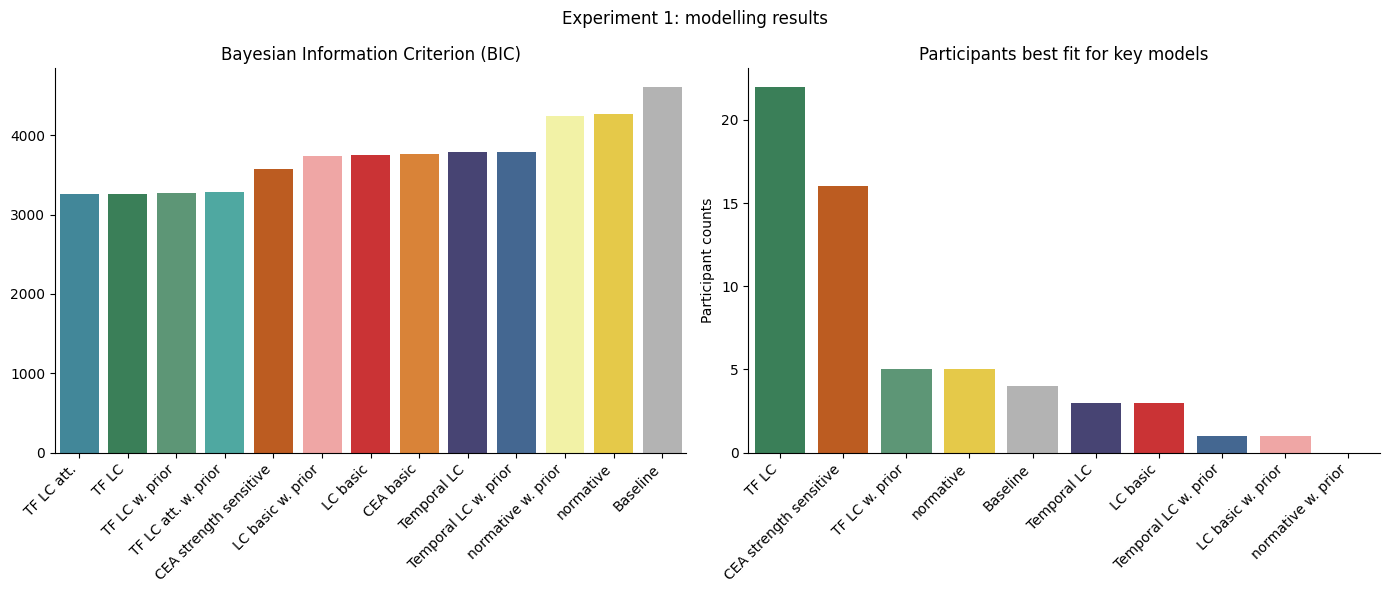

In [404]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_exp_bic_plot = dfs_table[0][['BIC group']].transpose()
df_exp_bic_plot = df_exp_bic_plot[df_exp_bic_plot.mean().sort_values().index.to_list()]
colors = gen_colors(df_exp_bic_plot.columns, color_dict)
sns.set_palette(colors)
sns.barplot(data=df_exp_bic_plot, ax=axs[0])
axs[0].set_xticklabels(df_exp_bic_plot.columns, rotation=45, ha='right')
axs[0].set_xlabel('')
axs[0].set_title('Bayesian Information Criterion (BIC)')
sns.despine()

# Participants' best fit
select = 'select_all'
df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[df_bic.experiment == 'experiment_1'][['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')
axs[1].set_yticks([0, 5, 10, 15, 20])
axs[1].set_title('Participants best fit for key models')
axs[1].set_ylabel('Participant counts')

sns.despine()
fig.suptitle('Experiment 1: modelling results')
plt.tight_layout()
plt.show()

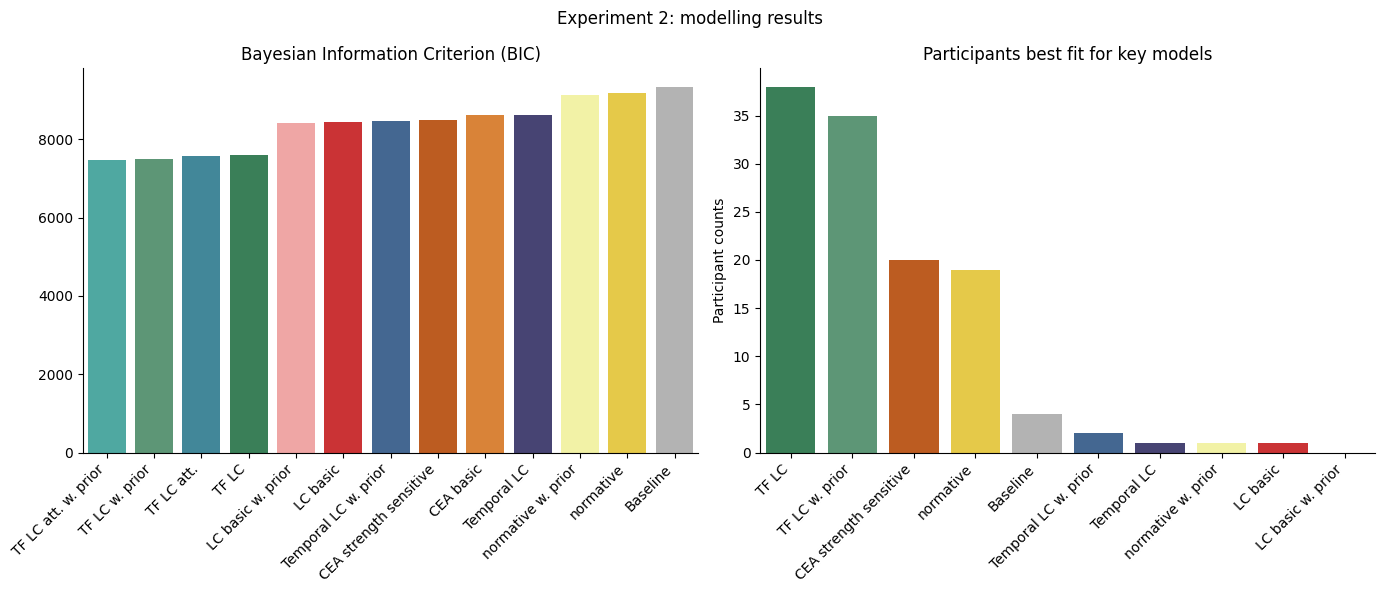

In [405]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_exp_bic_plot = dfs_table[1][['BIC group']].transpose()
df_exp_bic_plot = df_exp_bic_plot[df_exp_bic_plot.mean().sort_values().index.to_list()]
colors = gen_colors(df_exp_bic_plot.columns, color_dict)
sns.set_palette(colors)
sns.barplot(data=df_exp_bic_plot, ax=axs[0])
axs[0].set_xticklabels(df_exp_bic_plot.columns, rotation=45, ha='right')
axs[0].set_xlabel('')
axs[0].set_title('Bayesian Information Criterion (BIC)')
sns.despine()

# Participants' best fit
select = 'select_all'
df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[df_bic.experiment == 'experiment_2'][['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')
axs[1].set_title('Participants best fit for key models')
axs[1].set_ylabel('Participant counts')

sns.despine()
fig.suptitle('Experiment 2: modelling results')
plt.tight_layout()
plt.show()

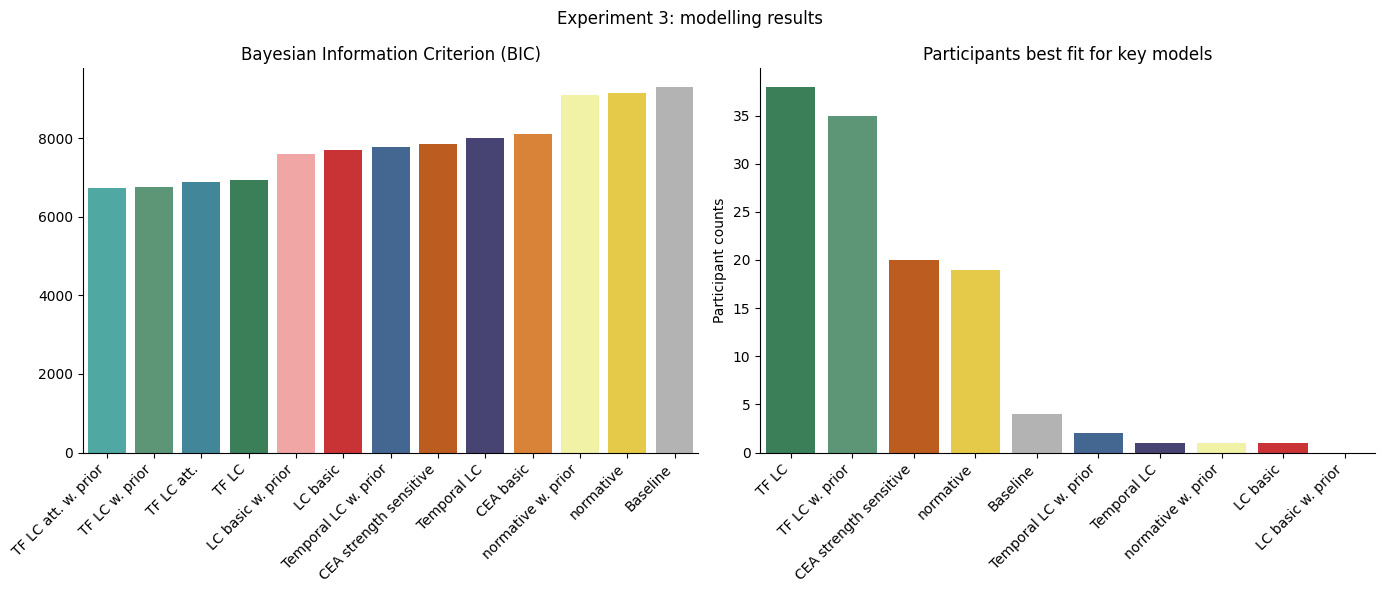

In [406]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_exp_bic_plot = dfs_table[2][['BIC group']].transpose()
df_exp_bic_plot = df_exp_bic_plot[df_exp_bic_plot.mean().sort_values().index.to_list()]
colors = gen_colors(df_exp_bic_plot.columns, color_dict)
sns.set_palette(colors)
sns.barplot(data=df_exp_bic_plot, ax=axs[0])
axs[0].set_xticklabels(df_exp_bic_plot.columns, rotation=45, ha='right')
axs[0].set_xlabel('')
axs[0].set_title('Bayesian Information Criterion (BIC)')
sns.despine()

# Participants' best fit
select = 'select_all'
df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[df_bic.experiment == 'experiment_2'][['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')
axs[1].set_title('Participants best fit for key models')
axs[1].set_ylabel('Participant counts')

sns.despine()
fig.suptitle('Experiment 3: modelling results')
plt.tight_layout()
plt.show()

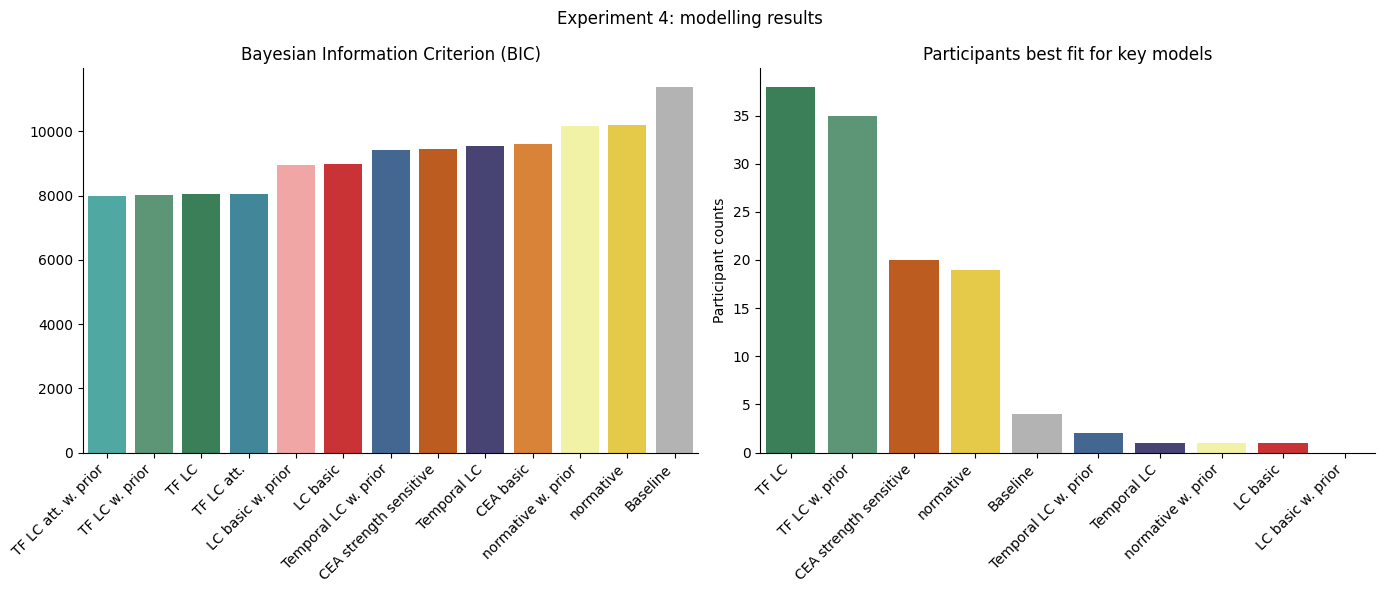

In [407]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

df_exp_bic_plot = dfs_table[3][['BIC group']].transpose()
df_exp_bic_plot = df_exp_bic_plot[df_exp_bic_plot.mean().sort_values().index.to_list()]
colors = gen_colors(df_exp_bic_plot.columns, color_dict)
sns.set_palette(colors)
sns.barplot(data=df_exp_bic_plot, ax=axs[0])
axs[0].set_xticklabels(df_exp_bic_plot.columns, rotation=45, ha='right')
axs[0].set_xlabel('')
axs[0].set_title('Bayesian Information Criterion (BIC)')
sns.despine()

# Participants' best fit
select = 'select_all'
df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[df_bic.experiment == 'experiment_2'][['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')
axs[1].set_title('Participants best fit for key models')
axs[1].set_ylabel('Participant counts')

sns.despine()
fig.suptitle('Experiment 4: modelling results')
plt.tight_layout()
plt.show()

## Print the mean BICs of participants best fit by TF LC, TF LC w. prior and CEA w. strength

In [408]:

print(f'TF LC w. prior mean={df_bic["TF LC w. prior"].mean()}, sd={df_bic["TF LC w. prior"].std()}')

print(f'TF LC mean={df_bic["TF LC"].mean()}, sd={df_bic["TF LC"].std()}')

print(f'CEA w. strenght mean={df_bic["CEA strength sensitive"].mean()}, sd={df_bic["CEA strength sensitive"].std()}')

TF LC w. prior mean=58.42099069980953, sd=17.74035390822204
TF LC mean=59.50878958004761, sd=17.70660892890353
CEA w. strenght mean=68.71359680716667, sd=14.622351663696925


In [409]:
df_tflcprior = df_bic[df_bic.final == 'TF LC w. prior']
print(f'TF LC w. prior mean={df_tflcprior["TF LC w. prior"].mean()}, sd={df_tflcprior["TF LC w. prior"].std()}')
df_tflc = df_bic[df_bic.final == 'TF LC']
print(f'TF LC mean={df_tflc["TF LC"].mean()}, sd={df_tflc["TF LC"].std()}')
df_cea = df_bic[df_bic.final == 'CEA strength sensitive']
print(f'CEA w. strenght mean={df_cea["CEA strength sensitive"].mean()}, sd={df_cea["CEA strength sensitive"].std()}')

TF LC w. prior mean=51.757288522040824, sd=14.957960000218216
TF LC mean=48.64768701946565, sd=17.000340909881007
CEA w. strenght mean=55.08740390936708, sd=15.065909549831046


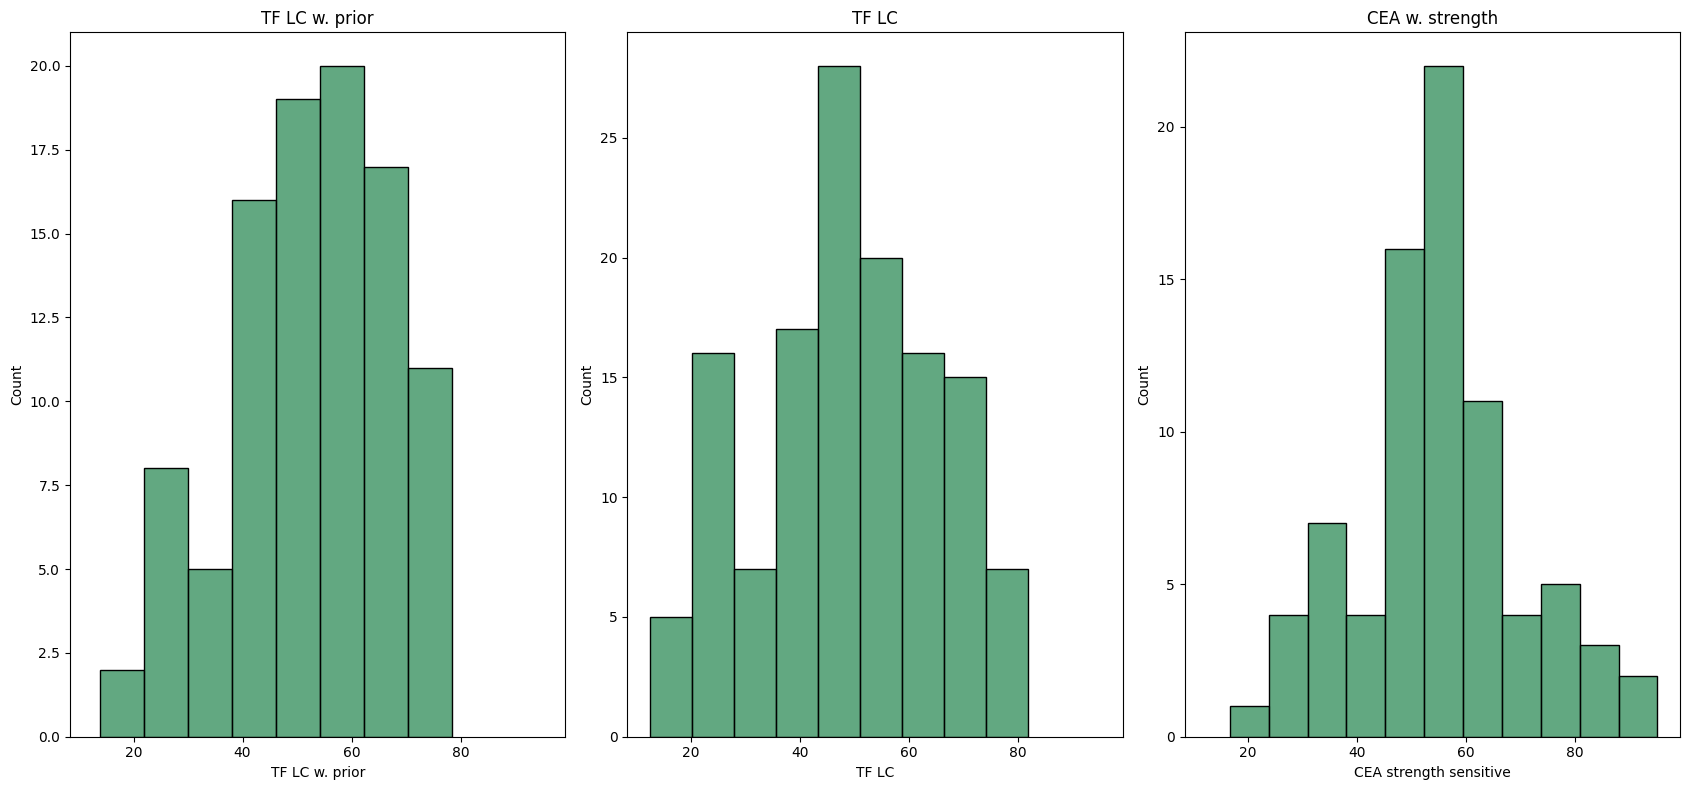

In [410]:
fig, axs = plt.subplots(1, 3, figsize=(17, 8), sharex=True)

sns.histplot(df_tflcprior["TF LC w. prior"], ax=axs[0])
axs[0].set_title('TF LC w. prior')

sns.histplot(df_tflc["TF LC"], ax=axs[1])
axs[1].set_title('TF LC')

sns.histplot(df_cea["CEA strength sensitive"], ax=axs[2])
axs[2].set_title('CEA w. strength')

plt.tight_layout()
plt.show()